In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9506172839506173, Loss: 0.26319263599537035
Checkpoint 200, Accuracy: 0.9567901234567902, Loss: 0.21729732442785193
Checkpoint 300, Accuracy: 0.9567901234567902, Loss: 0.1724529266357422
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.13404503575077764
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.12710698445638022


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9881621  0.00944555 0.00239233]
[0. 1. 0.] <-> [2.1359881e-02 9.7857040e-01 6.9618909e-05]
[0. 0. 1.] <-> [0.6958823  0.00486978 0.29924798]
[1. 0. 0.] <-> [0.9844934  0.00200667 0.01349998]
[0. 0. 1.] <-> [2.443876e-02 7.022268e-04 9.748590e-01]
[1. 0. 0.] <-> [0.9763352  0.01144375 0.01222104]
[1. 0. 0.] <-> [0.99456114 0.00196599 0.00347289]
[1. 0. 0.] <-> [0.9931514 0.0030897 0.0037588]
[0. 1. 0.] <-> [2.1568323e-02 9.7836280e-01 6.8796973e-05]
[1. 0. 0.] <-> [0.9734501  0.0033628  0.02318699]
[0. 1. 0.] <-> [2.5656365e-02 9.7425735e-01 8.6263877e-05]
[1. 0. 0.] <-> [0.994214   0.00156311 0.00422279]
[0. 0. 1.] <-> [0.27273795 0.00285118 0.72441083]
[1. 0. 0.] <-> [0.8201916  0.17782527 0.00198316]
[1. 0. 0.] <-> [0.9335698  0.04894004 0.01749018]
[1. 0. 0.] <-> [0.9241194  0.07359985 0.00228068]
[1. 0. 0.] <-> [0.9555046  0.00195882 0.04253656]
[0. 1. 0.] <-> [2.1576509e-02 9.7835356e-01 6.9840200e-05]
[1. 0. 0.] <-> [0.9453578  0.00558977 0.04905241]
[1. 0. 0.] 

In [12]:
# Testing Performance

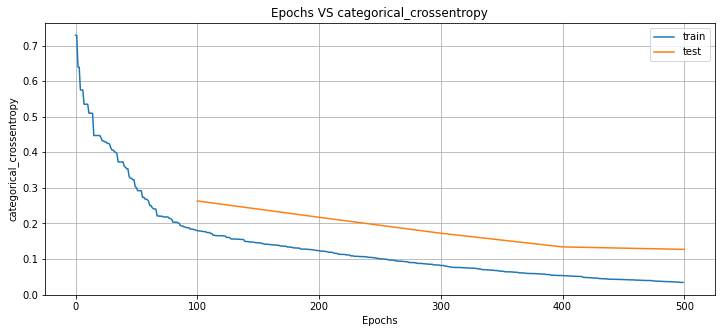

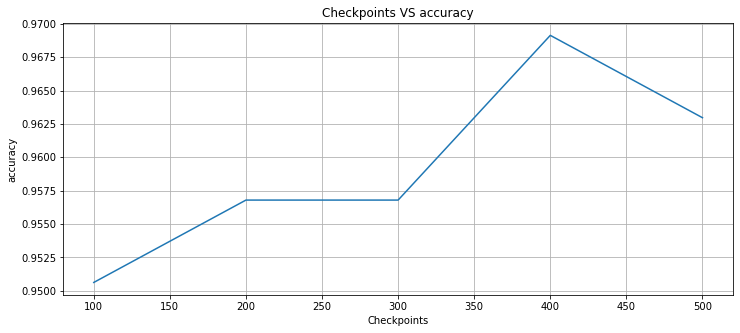

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9506172839506173, 'mean_square_error': 0.13606172701749242, 'categorical_crossentropy': 0.26319263599537035, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 7, 'tn_hit': 23, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 2}, 2: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 5}}, 'checkpoint': 100} 


{'accuracy': 0.9567901234567902, 'mean_square_error': 0.1129843158382938, 'categorical_crossentropy': 0.21729732442785193, 'precision': 0.9351851851851852, 'recall': 0.9351851851851852, 'f1': 0.9351851851851852, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 6, 'tn_hit': 24, 'fn_hit': 1}, 1: {'tp_hit': 15, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 5}}, 'checkpoint': 200} 


{'accuracy': 0.9567901234567902, 'mean_square_error': 0.0913274354361897, 'categorical_crossentropy': 0.1724529266357422, 'precision'

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[-1.7190206   2.5861773   2.688952    0.86516756 -0.98732734]
 bias: -1.7279043197631836

Neuron 1: weights:
[ 0.63563955  3.         -1.3348026  -1.4201599  -2.9482903 ]
 bias: 2.2331807613372803

Neuron 2: weights:
[-0.89319956  2.3754528   1.511982   -1.9900509  -1.2832333 ]
 bias: 1.6107878684997559

Neuron 3: weights:
[ 1.360099   -2.6625414  -2.455337   -1.0073141  -0.51069474]
 bias: 0.8093440532684326

$
Layer 2
Neuron 0: weights:
[-3.         3.         1.6851937  2.3205636]
 bias: -2.4917449951171875

Neuron 1: weights:
[ 3.          0.23037805  1.1379728  -2.3385198 ]
 bias: -1.360785961151123

Neuron 2: weights:
[-2.7295074 -3.        -2.5352018  1.8699925]
 bias: 1.7091690301895142

$

